In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import norm

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import pyplot
from sklearn.decomposition import PCA
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import quantile_transform

### Funciton Defined


In [2]:
def feature_selection(data_df, variation_threshold):
    pca = PCA()
    pca.fit(data_df)
    cum_variation = np.cumsum(pca.explained_variance_ratio_)
    feature_number = (cum_variation > variation_threshold).argmax(axis=0) + 1
    result_df = pd.DataFrame(
        data=np.vstack(
            [
                pca.explained_variance_,
                pca.explained_variance_ratio_ * 100,
                cum_variation * 100,
            ]
        ).T,
        columns=["Eigenvalue", "Variation explained(%)", "Cumulative(%)"],
        index=np.arange(1, data_df.shape[1] + 1),
    )
    result_df = round(result_df, 2)
    display(result_df)
    print("Selected Feature number: ", feature_number)

    return feature_number

### Data Input



In [3]:
rawdata_df = pd.read_csv("../data/SME_dataset.csv", index_col=0)
rawdata_df.head()

,status,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24
X1,,,,,,,,,,,,,,,,,,,,,
2,1,3.30,0.62,1.30,0.96,0.70,0.94,-21.75,-0.12,-0.53,...,-0.01,1,1,1,1,7,25,8,36635,4635
3,1,-7.93,-0.19,0.87,1.35,1.34,225.95,-42.44,-0.59,-8.12,...,-0.10,1,1,1,1,1,42,65,29970,4791
7,1,1.24,0.41,1.81,1.14,0.65,1.10,-10.84,-0.08,-0.21,...,0.00,1,1,1,1,30,43,21,7052,4752
10,1,-1.16,-0.68,0.14,1.60,0.87,2.23,-16.29,-0.27,-0.05,...,-0.07,1,1,1,1,48,31,12,4276,4771
12,1,-1.90,-0.86,0.47,0.42,0.42,-1.78,-13.83,-0.24,-0.23,...,-0.17,1,1,1,1,0,53,156,3799,3212


## Exploratory Data Analysis (EDA)

In [4]:

rawdata_df.iloc[:,1:].describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24
count,15045.000000,15045.000000,15045.000000,15045.000000,15045.000000,15045.000000,15045.000000,15045.000000,15045.000000,15045.000000,...,15045.000000,15045.000000,15045.000000,15045.000000,15045.000000,15045.000000,15045.000000,15045.000000,15045.000000,15045.000000
mean,8.894744,1.258207,1.462277,1.541156,1.189098,7.841478,23.228248,0.028451,-0.065396,1.368502,...,0.069327,0.179462,0.205317,0.935593,0.241476,104.540047,76.215487,95.752742,3397.433034,4572.634031
std,19.381710,3.341354,0.798856,1.212106,1.007325,23.882682,72.012435,0.146681,0.792478,1.060359,...,0.219726,0.383751,0.403947,0.245484,0.427992,351.177911,114.619017,132.276740,7532.012991,1945.144547
min,-67.150000,-9.590000,0.100000,0.000000,-0.020000,-33.140000,-285.860000,-1.340000,-8.930000,0.000000,...,-2.660000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,100.000000
25%,1.250000,0.000000,1.070000,0.970000,0.620000,0.940000,1.250000,0.010000,0.000000,0.690000,...,0.020000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,602.000000,3250.000000
50%,3.730000,0.060000,1.200000,1.220000,0.980000,1.750000,3.610000,0.030000,0.070000,1.160000,...,0.060000,0.000000,0.000000,1.000000,0.000000,20.000000,51.000000,67.000000,1146.000000,4642.000000
75%,9.850000,1.170000,1.540000,1.720000,1.400000,4.790000,16.830000,0.070000,0.210000,1.740000,...,0.120000,0.000000,0.000000,1.000000,0.000000,80.000000,100.000000,135.000000,2759.000000,5510.000000
max,207.090000,33.380000,8.270000,15.890000,10.910000,300.770000,571.220000,0.510000,1.280000,8.500000,...,1.410000,1.000000,1.000000,1.000000,1.000000,5569.000000,1493.000000,1531.000000,79454.000000,9609.000000


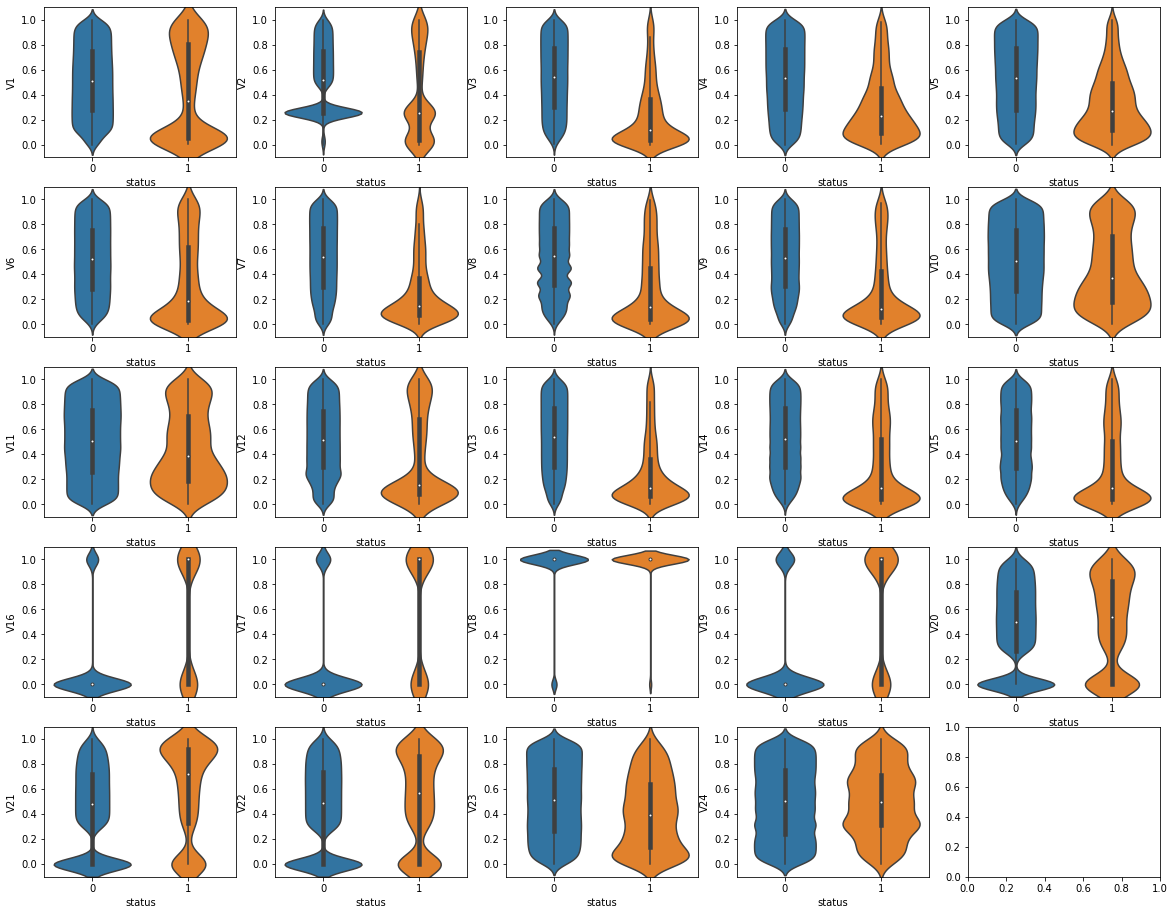

In [5]:
fig,ax=plt.subplots(5,5,figsize=(10,10))
rawdata_unif_df=rawdata_df.copy()
rawdata_unif_df.iloc[:,1:]=quantile_transform(rawdata_unif_df.iloc[:,1:])
for i in range(1, len(rawdata_unif_df.columns)):
    sns.violinplot(data=rawdata_unif_df,y=rawdata_unif_df.columns[i], x='status',ax=ax[(i-1)//5][(i-1)%5])
    ax[(i-1)//5][(i-1)%5].set_ylim([-.1, 1.1])
fig.set_size_inches(20, 16)

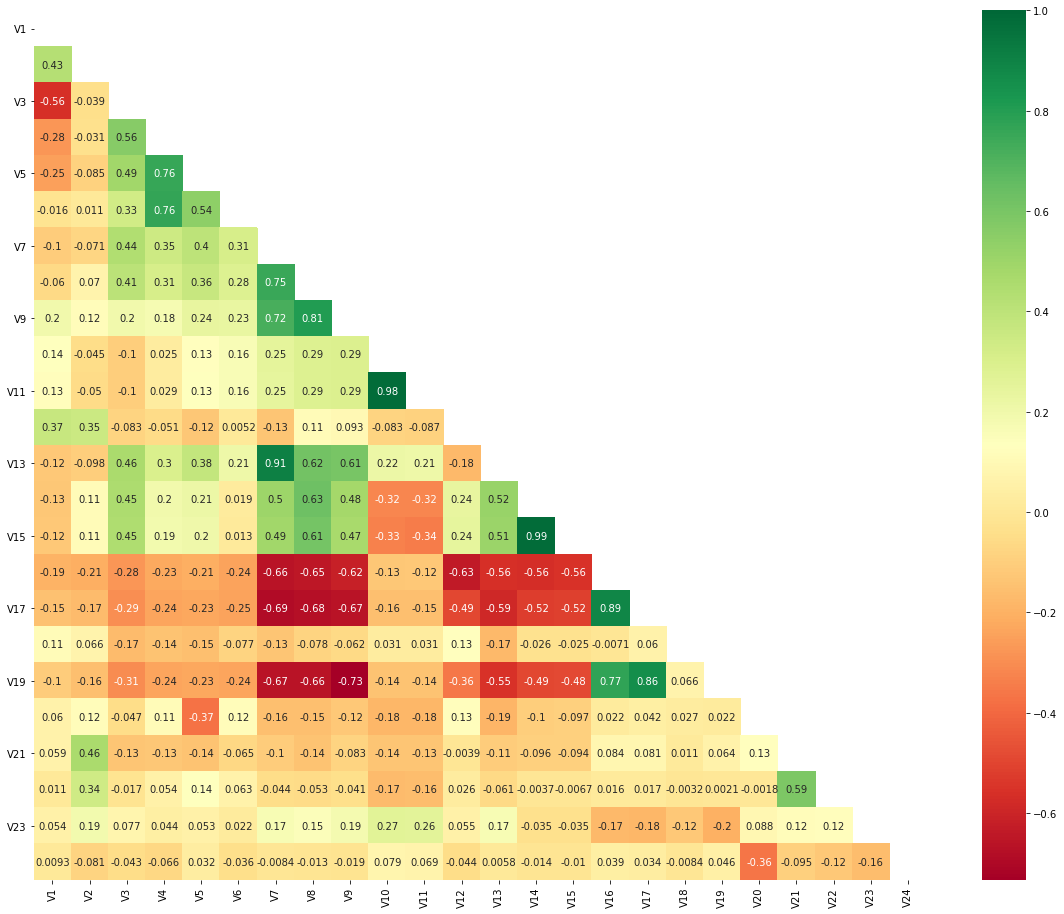

In [6]:
corr = rawdata_unif_df.drop(['status'], axis=1,).corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
# mask[np.abs(corr) < 0.85] = True
sns.heatmap(corr, annot=True, mask=mask, cmap='RdYlGn')
fig = plt.gcf()
fig.set_size_inches(20, 16)

In [7]:
# Feature Engineering
adj_features_df = rawdata_df.copy()
adj_features_df["V25"] = adj_features_df["V23"] * adj_features_df["V15"]
adj_features_df["M1"] = adj_features_df["V23"] / adj_features_df["V11"]
adj_features_df["M2"] = adj_features_df["V25"] / adj_features_df["V14"]
adj_features_df["M3"] = adj_features_df["M2"] * adj_features_df["V21"]
adj_features_df["M4"] = adj_features_df["M2"] * adj_features_df["V22"]
adj_features_df["M5"] = adj_features_df["M1"] / (adj_features_df["V1"] + 1)
adj_features_df["M6"] = adj_features_df["M5"] * adj_features_df["V2"]
adj_features_df["M7"] = adj_features_df["M1"] / adj_features_df["V3"]
adj_features_df["M8"] = adj_features_df["M7"] * adj_features_df["V4"]
adj_features_df["V26"] = (
    adj_features_df["M8"] - adj_features_df["M3"] - adj_features_df["M4"]
) / adj_features_df["M6"]
adj_features_df["V27"]=adj_features_df["V18"]/adj_features_df["V25"]
adj_features_df["V26"].replace([np.inf, -np.inf], [1, -1], inplace=True)
for col in adj_features_df.columns[1:]:
    adj_features_df = adj_features_df[
        (adj_features_df[col] != np.inf) & (adj_features_df[col] != -np.inf)
    ]
adj_features_df = adj_features_df.drop(
    [
        "M1",
        "M2",
        "M3",
        "M4",
        "M5",
        "M6",
        "M7",
        "M8",
        'V24',
        'V18',
        'V10',
        'V11',
        'V14',
        'V7',
        'V16',
        'V17'
    ],
    axis=1,
)
adj_features_df=adj_features_df.dropna()
data_status = adj_features_df["status"]
adj_features_df=adj_features_df.drop(["status"], axis=1)
adj_features_std_df = (
    adj_features_df - np.mean(adj_features_df)) / np.std(adj_features_df)

In [8]:
adj_features_df.describe()

,V1,V2,V3,V4,V5,V6,V8,V9,V12,V13,V15,V19,V20,V21,V22,V23,V25,V26,V27
count,14720.000000,14720.000000,14720.000000,14720.000000,14720.000000,14720.000000,14720.000000,14720.000000,14720.000000,14720.000000,14720.000000,14720.000000,14720.000000,14720.000000,14720.000000,14720.000000,14720.000000,1.472000e+04,14720.000000
mean,8.578177,1.253062,1.467539,1.545971,1.192312,7.776886,0.029460,-0.056980,0.204764,37.574605,0.070851,0.230571,105.096467,76.210190,95.955707,3387.156997,244.117724,-5.973685e+03,0.015370
std,18.397584,3.298954,0.804153,1.216816,1.011140,23.820795,0.148035,0.787555,0.481184,93.482287,0.221663,0.421212,351.302670,114.828291,132.242379,7515.102144,1126.654211,6.324187e+04,0.122837
min,-67.150000,-9.590000,0.140000,0.010000,-0.020000,-33.140000,-1.340000,-8.930000,-3.490000,-208.860000,-2.660000,0.000000,0.000000,0.000000,0.000000,2.000000,-36548.280000,-3.982522e+06,-5.263158
25%,1.240000,0.000000,1.070000,0.970000,0.620000,0.940000,0.010000,0.000000,0.010000,2.660000,0.030000,0.000000,1.000000,0.000000,0.000000,604.000000,25.240000,-1.281689e+03,0.001339
50%,3.680000,0.070000,1.200000,1.230000,0.980000,1.745000,0.040000,0.070000,0.100000,7.730000,0.060000,0.000000,21.000000,51.000000,68.000000,1145.500000,73.200000,-2.783974e+02,0.007665
75%,9.640000,1.180000,1.550000,1.730000,1.410000,4.760000,0.080000,0.220000,0.380000,29.137500,0.120000,0.000000,81.000000,100.000000,136.000000,2749.250000,208.320000,-1.000000e+00,0.020675
max,207.090000,33.380000,8.270000,15.890000,10.910000,300.770000,0.510000,1.280000,3.950000,750.360000,1.410000,1.000000,5569.000000,1493.000000,1531.000000,79454.000000,35312.160000,1.862275e+02,11.111111


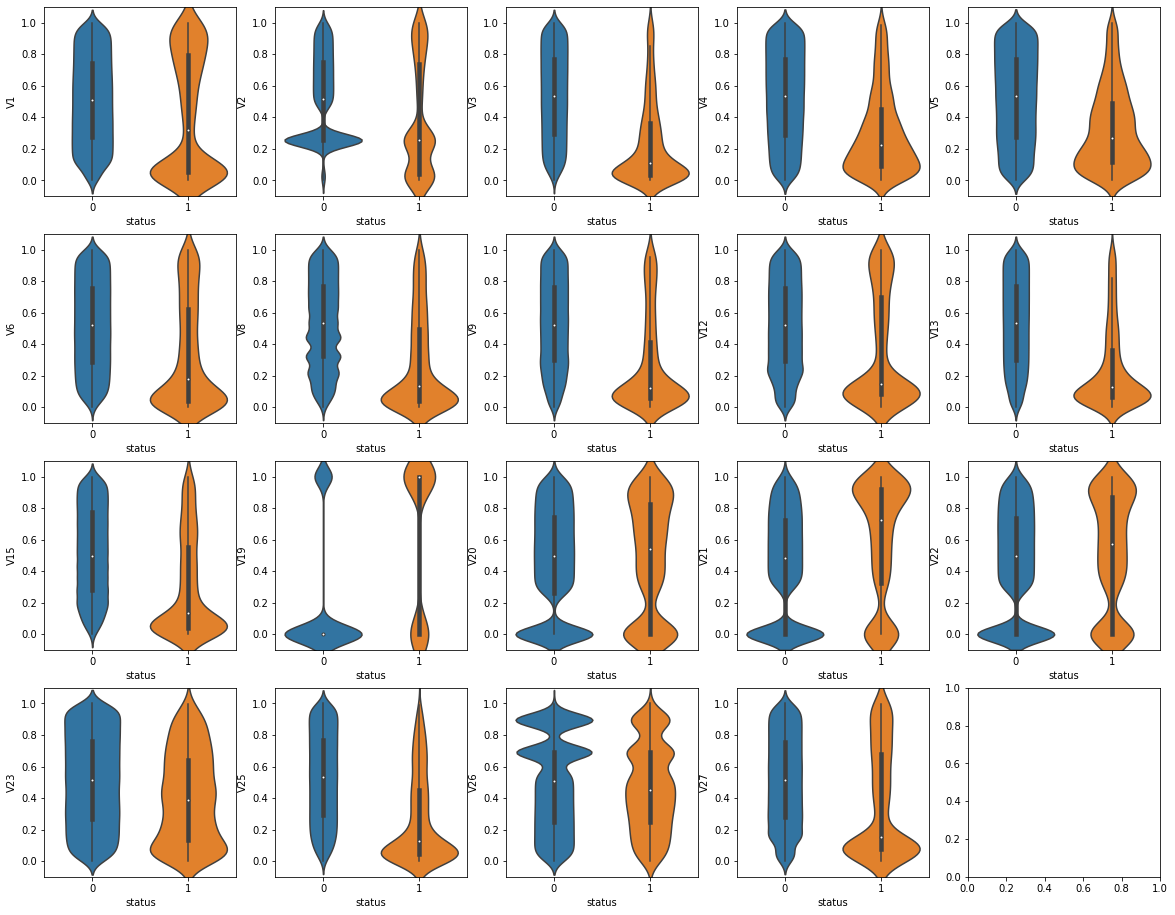

In [9]:
fig,ax=plt.subplots(4,5,figsize=(10,10))
adj_features_unif_df=adj_features_df.copy()
adj_features_unif_df['status']=data_status
adj_features_unif_df.iloc[:,:-1]=quantile_transform(adj_features_unif_df.iloc[:,:-1])
for i in range(len(adj_features_unif_df.columns)-1):
    sns.violinplot(data=adj_features_unif_df,y=adj_features_unif_df.columns[i], x='status',ax=ax[i//5][i%5])
    ax[i//5][i%5].set_ylim([-.1, 1.1])
fig.set_size_inches(20, 16)

## Machine Learning Clustering

In [10]:
def gen_summary_df(data_status, pred_vec):
    classified_df = pd.DataFrame({"default": data_status, "cluster": pred_vec})
    classified_df["counter"] = 1
    result_df=pd.merge(
        classified_df.groupby(["cluster", "default"]).count(),
        classified_df.groupby(["cluster", "default"])
        .sum()
        .groupby(level=0)
        .apply(lambda x: round(100 * x / float(x.sum()), 2)),
        how="right",
        on=["cluster", "default"],
    )
    result_df=result_df.reset_index()
    result_df.columns=['cluster','default','frequency','perct%']
    freq_series=result_df.groupby("cluster")["frequency"].sum()
    for i in range(len(freq_series)):
        new_row=pd.DataFrame([[i,'Total',freq_series[i],round(100*freq_series[i]/np.sum(freq_series),2)]],columns=result_df.columns)
        result_df=result_df.append(new_row)
    result_df=result_df.set_index(["cluster", "default"]).sort_index()
    return result_df

In [11]:
# kMeans
estimator = KMeans(n_clusters=2)
kmeans_pred = estimator.fit_predict(adj_features_std_df)
gen_summary_df(data_status,kmeans_pred)

frequency  perct%
cluster default                   
0       0            11781   94.25
        1              719    5.75
        Total        12500   84.92
1       0             1359   61.22
        1              861   38.78
        Total         2220   15.08

In [12]:
# AgglomerativeClustering
estimator = AgglomerativeClustering(n_clusters=2, affinity='cosine', linkage='complete')
agg_pred = estimator.fit_predict(adj_features_std_df)
gen_summary_df(data_status, agg_pred)

frequency  perct%
cluster default                   
0       0            11768   93.81
        1              776    6.19
        Total        12544   85.22
1       0             1372   63.05
        1              804   36.95
        Total         2176   14.78

In [40]:
# GMM
estimator = GaussianMixture(
    n_components=2, covariance_type="full", init_params="kmeans", random_state=None
)
gmm_pred = estimator.fit_predict(adj_features_std_df)
gen_summary_df(data_status,gmm_pred)

frequency  perct%
cluster default                   
0       0             3402   78.84
        1              913   21.16
        Total         4315   29.31
1       0             9738   93.59
        1              667    6.41
        Total        10405   70.69

In [50]:
# DEC neural network

from DEC import *
from keras.optimizers import SGD, Adam

input_x = adj_features_df

# hyper-params
dims = [input_x.shape[-1], 500, 500, 2000, 15]
init = "glorot_uniform"
tol = 0.0001
maxiter = 1000
update_interval = 100
n_clusters = 2
n_epochs = 100
batch_size = 128
pretrain_optimizer = SGD(lr=0.001, momentum=0.9, decay=0.001 / n_epochs)
# pretrain_optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
optimizer = SGD(lr=0.001, momentum=0.9, decay=0.001 / n_epochs)

autoencoder, encoder = autoencoder(dims, act="relu", init=init, dropout=0.2)
autoencoder.compile(optimizer=pretrain_optimizer, loss="mse")
autoencoder.fit(input_x, input_x, batch_size=batch_size, epochs=n_epochs)
kmeans = KMeans(n_clusters=n_clusters)
y_init = kmeans.fit(encoder.predict(input_x)).cluster_centers_
loss = 1
index = 0
index_array = np.arange(input_x.shape[0])
clustering_layer = ClusteringLayer(
    n_clusters=n_clusters, name="clustering", weights=[y_init]
)(encoder.output)
model = Model(inputs=encoder.input, outputs=[autoencoder.output, clustering_layer])
model.compile(loss=["mse", "kld"], loss_weights=[0.1, 1], optimizer=optimizer)
y_pred_last = kmeans.predict(encoder.predict(input_x))
for ite in range(maxiter):
    if ite % update_interval == 0:
        _, q = model.predict(input_x, verbose=0)
        p = target_distribution(q)  # update the auxiliary target distribution p

        # evaluate the clustering performance
        y_pred = q.argmax(1)

        # check stop criterion
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)
        print("the " + str(ite) + "th training." + "Loss: " + str(loss))
        if ite > 0 and delta_label < tol:
            print("delta_label = ", delta_label, " < %d" % tol)
            print("Reached tolerance threshold. Stopping training.")
            break
    idx = index_array[
        index * batch_size : min((index + 1) * batch_size, input_x.shape[0])
    ]
    loss = model.train_on_batch(x=input_x.iloc[idx], y=[input_x.iloc[idx], p[idx]])
    index = index + 1 if (index + 1) * batch_size <= input_x.shape[0] else 0
_, q = model.predict(input_x, verbose=0)

Epoch 1/100
14730/14730 [==============================] - 3s 235us/step - loss: 1.1571
Epoch 2/100
14730/14730 [==============================] - 3s 191us/step - loss: 0.7999
Epoch 3/100
14730/14730 [==============================] - 3s 193us/step - loss: 0.6942
Epoch 4/100
14730/14730 [==============================] - 3s 192us/step - loss: 0.6262
Epoch 5/100
14730/14730 [==============================] - 3s 193us/step - loss: 0.5929
Epoch 6/100
14730/14730 [==============================] - 3s 192us/step - loss: 0.5541
Epoch 7/100
14730/14730 [==============================] - 3s 193us/step - loss: 0.5460
Epoch 8/100
14730/14730 [==============================] - 3s 193us/step - loss: 0.5110
Epoch 9/100
14730/14730 [==============================] - 3s 193us/step - loss: 0.4933
Epoch 10/100
14730/14730 [==============================] - 3s 192us/step - loss: 0.4756
Epoch 11/100
14730/14730 [==============================] - 3s 193us/step - loss: 0.4657
Epoch 12/100
14730/14730 [====

In [188]:
gen_summary_df(data_status,np.argmax(q, 1))

frequency  perct%
cluster default                   
0       0            11423   94.44
        1              673    5.56
        Total        12096   82.12
1       0             1726   65.53
        1              908   34.47
        Total         2634   17.88

## SVD decomposition

In [13]:

variation_threshold = 0.95
feature_number = feature_selection(adj_features_std_df, variation_threshold)
U, sigma, V = np.linalg.svd(adj_features_std_df, full_matrices=False)
Feature_vec = pd.DataFrame(U[:, :feature_number].dot(np.diag(sigma[:feature_number])))
Feature_vec.head()

,Eigenvalue,Variation explained(%),Cumulative(%)
1,3.39,17.85,17.85
2,2.10,11.08,28.93
3,1.60,8.41,37.33
4,1.45,7.63,44.96
5,1.24,6.54,51.50
6,1.12,5.91,57.41
7,1.03,5.43,62.84
8,1.01,5.31,68.15
9,0.92,4.83,72.98
10,0.89,4.68,77.66


Selected Feature number:  16


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,1.492412,0.471183,-2.096692,2.028657,2.032142,0.569869,0.153501,0.679644,0.001719,0.247437,0.613296,-0.361608,-0.529385,0.356301,2.303799,-0.237783
1,5.567042,6.285023,0.847325,0.529229,4.436588,2.555273,2.927587,3.124794,2.139825,5.138808,-4.609115,3.283524,-1.079354,1.364558,4.514784,5.013970
2,2.298914,1.100736,-1.254605,-0.383453,0.346678,0.294505,0.070338,0.229423,-0.124617,0.270016,0.333199,-0.191583,0.546422,0.463881,-0.818507,-0.541065
3,2.965025,0.929334,-1.130463,-0.002179,-0.406699,0.046631,-0.300586,0.075717,0.004388,0.310234,0.134148,-0.022312,0.373300,0.460169,-0.049168,-0.995643
4,3.091264,0.536297,-0.287480,0.423935,-0.257169,0.311550,-0.050444,-0.224083,-0.257224,-0.298633,-0.426620,-0.256398,-0.537688,-1.440703,-0.228064,0.365913


In [14]:
save_dir='../data_stage2/'
adj_features_df.merge(pd.DataFrame({"status":data_status},index=adj_features_df.index),on='X1').to_csv(save_dir+'new_feature.csv')
Feature_vec['X1']=data_status
Feature_vec.set_index('X1',inplace=True)
Feature_vec['status']=data_status
Feature_vec.to_csv(save_dir+'new_svd.csv')
pd.DataFrame({"X1":adj_features_df.index,"cluster": kmeans_pred,"status":data_status}).to_csv(save_dir+'kmeans.csv')